## Imports

In [20]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import metrics

import pandas as pd
import numpy as np

import backtrader as bt

## Data laoding from CSV
### Stockdata
* Load data from CSV

In [3]:
stock_list = pd.read_csv('clean_data.csv',sep=',')
u_symbol = stock_list['symbol'].unique()
date = pd.Series(stock_list['datetime'])
stock_list.drop(['datetime'],axis=1,inplace=True)
stock_list['date'] = date.apply(lambda x: np.datetime64(x))
stock_data = {}

for symbol in u_symbol:
    stock_data[symbol] = stock_list[stock_list['symbol'] == symbol]

stock_data[list(stock_data.keys())[0]]

,open,high,low,close,volume,symbol,log_returns,date
0,32.30,33.58,32.30,32.84,7315000.0,1179.HK,0.056371,2020-09-23
1,34.08,34.20,33.50,33.73,2797160.0,1179.HK,0.026740,2020-09-24
2,33.12,33.12,32.30,32.62,3964430.0,1179.HK,-0.033462,2020-09-25
3,32.68,33.22,32.68,33.08,763500.0,1179.HK,0.014003,2020-09-28
4,33.58,34.18,33.58,33.99,2398130.0,1179.HK,0.027137,2020-09-29
...,...,...,...,...,...,...,...,...
838,29.20,29.20,28.30,28.85,2695218.0,1179.HK,-0.012059,2024-02-22
839,29.10,30.05,29.10,29.70,1548300.0,1179.HK,0.029037,2024-02-23
840,30.35,31.00,30.30,30.40,3111600.0,1179.HK,0.023296,2024-02-26
841,29.60,30.10,29.15,29.95,2316600.0,1179.HK,-0.014913,2024-02-27


<Axes: xlabel='log_returns', ylabel='date'>

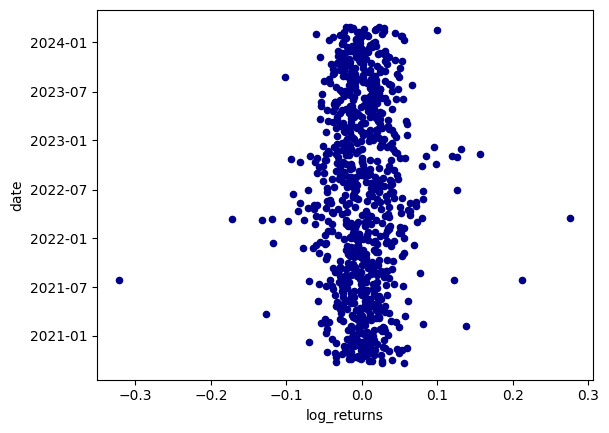

In [4]:
# visualize one stock
stock_data[list(stock_data.keys())[0]].plot.scatter(x='log_returns',y='date',c='DarkBlue')

### Short-selling-reports

In [5]:
short_list = pd.read_excel('stocks_with_listings.xlsx')

## Label Rows
* read time shifted `adj_close` into `signal` such that it can be compared to current date in one row without reverse lookupQQ
* compare previous day and set 1 if stock has risen

In [6]:
# label function
# 1 lower than previous day
# 0 higher than previous day
def label_row(row):
    if (row['signal'] - row['log_returns']) < 0:
        return 1
    else:
        return 0
def label_df(df):
    df['signal'] = df['log_returns'].shift(1)
    df.fillna(0)
    df['signal'] = df.apply(label_row,axis=1)
    return df

In [7]:
length = 0
amount_0 = 0
amount_1 = 0 
for ticker in stock_data:
#     stock_data[ticker]['singal'] = stock_data[ticker]['log_returns'].shift(1)
    stock_data[ticker] = label_df(stock_data[ticker])
#     signal = np.array(stock_data[ticker]['signal'])
    amount_0 = amount_0 + len(np.where(stock_data[ticker]['signal'] == 0)[0])
    amount_1 = amount_1 + len(np.where(stock_data[ticker]['signal'] == 1)[0])
print("Total amount of 0's:{0}\nTotal amount of 1's:{1}".format(amount_0,amount_1))


C:\Users\Admin\AppData\Local\Temp\ipykernel_2608\2528212958.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = df['log_returns'].shift(1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2608\2528212958.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = df.apply(label_row,axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2608\2528212958.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Total amount of 0's:538242
Total amount of 1's:470225


C:\Users\Admin\AppData\Local\Temp\ipykernel_2608\2528212958.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = df.apply(label_row,axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2608\2528212958.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = df['log_returns'].shift(1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2608\2528212958.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

## Create Bands

In [8]:
# for i in stock_data:
#     df = stock_data[i]
#     if(df['signal'].shape[0] < 10):
#         print(i)
#         print(df['signal'].shape)

## Filter training data

In [9]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [10]:
stocks_after_report = {}

for index, row in short_list.iterrows():
    symbol = row['SYMBOL']
    date_report = row['Date']
    if symbol in list(stock_data.keys()):
        stock_df = stock_data[symbol]
        stock_start_date = nearest(np.array(stock_df['date']),date_report)
        condition = stock_df['date'] == stock_start_date
        start_index = stock_df.index[condition][0]
        # gets all entries of the stock after the shortselling repport for this stock has been rleases
        if(start_index > stock_df.index[-1]):
            print("start index df: {}, end index df: {}, date after report: {}".format(stock_df.index[0],stock_df.index[-1],start_index))
        result = stock_df.loc[start_index:].copy()
        # replace date with column that indicates how many days past release have passed
        incremental = np.arange(0,len(result.date))
        result['index'] = incremental
        # save each dataset
        stocks_after_report[symbol] = result


## Create Testsplit
* We create a testsplit at a certain date which allows for roughly 70% of the data to be before it for training.
* The other 30% will be after the date, we ensure this way that when we do out of sample testing that the training wasnt
"poisoned" with future data.

In [11]:
# Make sure all dates are in datetime format
short_list['Date'] = short_list['Date'].apply(lambda x: np.datetime64(x)) 
# Sort list by date ascending
short_list.sort_values(by=['Date'], inplace=True, ascending=True)
# Remove entries that arent in the dataset with 
short_list = short_list[short_list['SYMBOL'].isin(stocks_after_report)]
# Get amount of entries
sl_size = short_list.shape[0]
# Get index up to which 70% of the entries are.
position_training_block = int(sl_size*0.7)
# Create Testsplit
train_list = short_list.iloc[:position_training_block]
test_list = short_list.iloc[position_training_block:]

X_train = []
Y_train = []

X_test = []
Y_test = []

for ticker in train_list['SYMBOL']:
    x = np.array(stocks_after_report[ticker][['index','log_returns']])
    y = np.array(stocks_after_report[ticker][['signal']].shift(1).fillna(0))
    #TODO because of the shift right our first element of y is now nan we delete the first day for both. 
    # X_train.append(np.delete(x,0))
    # Y_train.append(np.delete(y,0))
    X_train.append(x) #shape (n,2)
    Y_train.append(y) #shape (n,1)



for ticker in test_list['SYMBOL']:
    x = np.array(stocks_after_report[ticker][['index','log_returns']])
    y = np.array(stocks_after_report[ticker][['signal']])
    X_test.append(x)
    # after shift for some reason values are float
    Y_test.append(y.astype(np.float64))

## Train SVR

In [24]:
# Define classifier
clf = xgb.XGBRegressor()
for x_train, y_train in zip(X_train, Y_train):
    # ravel() returns a continious flatened array 
    clf.fit(x_train,y_train)

### Insample Testing

In [25]:

def binary_convertor(value):
    if value >= 0.5:
        return 1
    else:
        return 0
for x_test, y_test in zip(X_train, Y_train):
    y_pred = clf.predict(x_test)
    y_pred_binary = list(map(binary_convertor,y_pred))
    print("Accuracy:",metrics.accuracy_score(y_test,y_pred_binary))
    print("Precision:",metrics.precision_score(y_test, y_pred_binary,pos_label=str(1),average="macro"))
    print("Recall:",metrics.recall_score(y_test, y_pred_binary,pos_label=str(1),average="macro"))


Accuracy: 0.4851190476190476
Precision: 0.49289830912121935
Recall: 0.49337068160597575
Accuracy: 0.3244609164420485
Precision: 0.45489296636085624
Recall: 0.4636625636884958
Accuracy: 0.5098730606488011
Precision: 0.5157300157300158
Recall: 0.5151402719264649
Accuracy: 0.5044490075290896
Precision: 0.5062954205674723
Recall: 0.5059032944871973
Accuracy: 0.484304932735426
Precision: 0.5057350492829048
Recall: 0.505183481713721
Accuracy: 0.48905109489051096
Precision: 0.4907791667727508
Recall: 0.4917279821627648
Accuracy: 0.4755244755244755
Precision: 0.4946208084812337
Recall: 0.4953180241725673
Accuracy: 0.5067567567567568
Precision: 0.5198953669701695
Recall: 0.5181563604645825
Accuracy: 0.5117999295526594
Precision: 0.5127185374417846
Recall: 0.5120080953898164
Accuracy: 0.4889502762430939
Precision: 0.4905190078600483
Recall: 0.49048846342660773
Accuracy: 0.5
Precision: 0.49965920004957093
Recall: 0.49966422466422467
Accuracy: 0.49733759318423854
Precision: 0.4988428987040465
Reca

c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is igno

Accuracy: 0.5180436847103513
Precision: 0.5306267806267806
Recall: 0.5273066502630163
Accuracy: 0.48024750118990955
Precision: 0.4807855909203059
Recall: 0.4823540074865631
Accuracy: 0.5200587084148728
Precision: 0.5234034071836187
Recall: 0.5213614859398144
Accuracy: 0.5072247135027405
Precision: 0.5099935218759621
Recall: 0.5092856177962836
Accuracy: 0.5202804206309464
Precision: 0.5215035456561807
Recall: 0.5207130118698231
Accuracy: 0.4672131147540984
Precision: 0.4639077340569878
Recall: 0.4641273076000959
Accuracy: 0.49319213313161875
Precision: 0.494848472786137
Recall: 0.4952597617976888
Accuracy: 0.4995
Precision: 0.5021030185013352
Recall: 0.5019315582203256
Accuracy: 0.5111804472178887
Precision: 0.5127728257971788
Recall: 0.5119200347881773
Accuracy: 0.5015822784810127
Precision: 0.5042259473165235
Recall: 0.5039067369508308
Accuracy: 0.5074309978768577
Precision: 0.5095367847411444
Recall: 0.5090738169095369
Accuracy: 0.4923913043478261
Precision: 0.4966308504826079
Recall

c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is igno

Accuracy: 0.486875
Precision: 0.4852702894294453
Recall: 0.4863638707419323
Accuracy: 0.5002981514609421
Precision: 0.5009252367517572
Recall: 0.5008946706644744
Accuracy: 0.5047318611987381
Precision: 0.5058324959587575
Recall: 0.5055268412454261
Accuracy: 0.5171428571428571
Precision: 0.5143872939925571
Recall: 0.5141683845423906
Accuracy: 0.49493029150823825
Precision: 0.49614144849137365
Recall: 0.4962222311493191
Accuracy: 0.49361430395913153
Precision: 0.49068371630481655
Recall: 0.4913642889773543
Accuracy: 0.4984005118362124
Precision: 0.498911439992386
Recall: 0.49895124131765356
Accuracy: 0.4971172325432415
Precision: 0.49679013757995216
Recall: 0.4968678899624738
Accuracy: 0.5005065856129686
Precision: 0.5004409171075838
Recall: 0.5004311371344573
Accuracy: 0.49416342412451364
Precision: 0.4995234822288986
Recall: 0.4995464294385842
Accuracy: 0.48793215916503585
Precision: 0.48726457637009923
Recall: 0.48774254493464053
Accuracy: 0.5045931758530183
Precision: 0.5090979221197

c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is igno

Accuracy: 0.5296969696969697
Precision: 0.5297315031567
Recall: 0.5295585175781938
Accuracy: 0.506268081002893
Precision: 0.5076832151300237
Recall: 0.5074237351190476
Accuracy: 0.5247042449547669
Precision: 0.52613425417673
Recall: 0.5253636102996443
Accuracy: 0.5143658023826209
Precision: 0.5156626358712264
Recall: 0.5150986539685534
Accuracy: 0.4794617563739377
Precision: 0.4793873618313715
Recall: 0.48040529695024076
Accuracy: 0.49002849002849
Precision: 0.49427612262294396
Recall: 0.4944693572496263
Accuracy: 0.5037720033528919
Precision: 0.501530567365489
Recall: 0.5014678176756742
Accuracy: 0.5068890500362582
Precision: 0.5103191139379317
Recall: 0.5099054716941409
Accuracy: 0.5025454545454545
Precision: 0.5044785877737823
Recall: 0.504349703458173
Accuracy: 0.49189985272459497
Precision: 0.4945313934275748
Recall: 0.49482802027989026
Accuracy: 0.49592290585618976
Precision: 0.49910363173721956
Recall: 0.49914754603251427
Accuracy: 0.5022421524663677
Precision: 0.506178567102644

c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is igno

Precision: 0.5025189353993854
Recall: 0.502440538548093
Accuracy: 0.492151431209603
Precision: 0.4974738701713407
Recall: 0.4976653231315753
Accuracy: 0.5102711585866886
Precision: 0.5112581758975943
Recall: 0.5108315778101874
Accuracy: 0.4888152444076222
Precision: 0.48899862570826713
Recall: 0.489273750686436
Accuracy: 0.5004149377593361
Precision: 0.5026925380698966
Recall: 0.5025768223783933
Accuracy: 0.47333333333333333
Precision: 0.4755312587770986
Recall: 0.47650282644540776
Accuracy: 0.4851244687310261
Precision: 0.48677532145274083
Recall: 0.48754646840148697
Accuracy: 0.49362786745964315
Precision: 0.49284347493302716
Recall: 0.492980115621625
Accuracy: 0.4700854700854701
Precision: 0.4676010133818371
Recall: 0.46549398090493976
Accuracy: 0.4948453608247423
Precision: 0.4939702610935488
Recall: 0.4940695356905588
Accuracy: 0.5077720207253886
Precision: 0.5085019344981394
Recall: 0.5082331042382588
Accuracy: 0.5238508239375542
Precision: 0.5255808593029688
Recall: 0.5250510139

c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is igno

Precision: 0.4771432888026151
Recall: 0.47763717805151173
Accuracy: 0.5
Precision: 0.5089285714285714
Recall: 0.508294930875576
Accuracy: 0.49894736842105264
Precision: 0.5014831765403848
Recall: 0.5014795861608633
Accuracy: 0.38238453276047263
Precision: 0.4444774892402921
Recall: 0.4164665910016879
Accuracy: 0.4816017316017316
Precision: 0.4888837557093393
Recall: 0.4889135886912905
Accuracy: 0.5032537960954447
Precision: 0.5020565540447152
Recall: 0.5020313434170821
Accuracy: 0.48085585585585583
Precision: 0.48313492063492064
Recall: 0.48341859413656285
Accuracy: 0.5163841807909605
Precision: 0.5164325842696629
Recall: 0.5164367816091954
Accuracy: 0.5068807339449541
Precision: 0.5092883482207368
Recall: 0.5091404163879687
Accuracy: 0.5185185185185185
Precision: 0.5189167683697224
Recall: 0.5188559424219852
Accuracy: 0.4889406286379511
Precision: 0.4888734089381356
Recall: 0.48885709942561806
Accuracy: 0.48717948717948717
Precision: 0.4876440167583137
Recall: 0.4876896821600939
Accur

c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is igno

Recall: 0.5046234999894921
Accuracy: 0.5
Precision: 0.49652220438737293
Recall: 0.4966186925611236
Accuracy: 0.5403624382207578
Precision: 0.5404494259634447
Recall: 0.5403150512419663
Accuracy: 0.9684908789386402
Precision: 0.9695111011437543
Recall: 0.966726859283039


c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is igno

### Outsample Testing

In [22]:
amount_0_pred = 0
amount_1_pred = 0
amount_0 = 0
amount_1 = 0
def binary_convertor(value):
    if value >= 0.5:
        return 1
    else:
        return 0
for x_test, y_test in zip(X_test, Y_test):
    y_pred = clf.predict(x_test)
    y_pred_binary = list(map(binary_convertor,y_pred))
    amount_0 = amount_0 + len(np.where(y_test == 0)[0])
    amount_1 = amount_1 + len(np.where(y_test == 1)[0])
    amount_0_pred = amount_0_pred + len(np.where(np.array(y_pred_binary) == 0)[0])
    amount_1_pred = amount_1_pred + len(np.where(np.array(y_pred_binary) == 1)[0])
    # if(y_pred.max() > a ):
    #     a = y_pred.max()
    # if(y_pred.min() < b ):      
    # #     b = y_pred.max()
    print("Accuracy:",metrics.accuracy_score(y_test,y_pred_binary))
    print("Precision:",metrics.precision_score(y_test, y_pred_binary,pos_label=str(1),average="macro"))
    print("Recall:",metrics.recall_score(y_test, y_pred_binary,pos_label=str(1),average="macro"))
# print("Total amount of 0's:{0}\nTotal amount of 1's:{1}".format(amount_0,amount_1))
# print("Total amount of predicted 0's:{0}\nTotal amount of predicted 1's:{1}".format(amount_0_pred,amount_1_pred))

Accuracy: 0.45365853658536587
Precision: 0.452116935483871
Recall: 0.4525
Accuracy: 0.46935201401050786
Precision: 0.46924654338269606
Recall: 0.4692729548019826
Accuracy: 0.44344703770197486
Precision: 0.4433016945655258
Recall: 0.4433016945655258
Accuracy: 0.5036101083032491
Precision: 0.4938904822250384
Recall: 0.4939340962068235
Accuracy: 0.45471014492753625
Precision: 0.4545078577336642
Recall: 0.45445344129554655
Accuracy: 0.45985401459854014
Precision: 0.459024292310781
Recall: 0.4592077387376584
Accuracy: 0.49264705882352944
Precision: 0.49299811200304255
Recall: 0.49303142953700574
Accuracy: 0.4499054820415879
Precision: 0.44994563973449303
Recall: 0.4499842762800538
Accuracy: 0.46935201401050786
Precision: 0.46924654338269606
Recall: 0.4692729548019826
Accuracy: 0.4596774193548387
Precision: 0.46058988258028594
Recall: 0.46084126596696773
Accuracy: 0.4847870182555781
Precision: 0.48064543742509847
Recall: 0.48137254901960785
Accuracy: 0.4845360824742268
Precision: 0.484913645

c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is igno

Accuracy: 0.41964285714285715
Precision: 0.41876750700280113
Recall: 0.41905901116427435
Accuracy: 0.4988558352402746
Precision: 0.4995429421768708
Recall: 0.49954960616725325
Accuracy: 0.46226415094339623
Precision: 0.4602678571428571
Recall: 0.4602216858854027
Accuracy: 0.46472019464720193
Precision: 0.46432178932178936
Recall: 0.46487094482595315
Accuracy: 0.4187192118226601
Precision: 0.4190947940947941
Recall: 0.419047619047619
Accuracy: 0.4463840399002494
Precision: 0.4467211067825392
Recall: 0.446912013536379
Accuracy: 0.47619047619047616
Precision: 0.47498084291187737
Recall: 0.4753857365431975
Accuracy: 0.49122807017543857
Precision: 0.4912720097146327
Recall: 0.4913316582914573
Accuracy: 0.48614609571788414
Precision: 0.4867361684558216
Recall: 0.48695299015128435
Accuracy: 0.46630727762803237
Precision: 0.4654344132638116
Recall: 0.4657016625973724
Accuracy: 0.4684931506849315
Precision: 0.4691475251703141
Recall: 0.4692513368983957
Accuracy: 0.43820224719101125
Precision: 0

c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is igno

Accuracy: 0.44573643410852715
Precision: 0.445576181292189
Recall: 0.44573643410852715
Accuracy: 0.4268292682926829
Precision: 0.42718348685537555
Recall: 0.42837301587301585
Accuracy: 0.483739837398374
Precision: 0.4814814814814815
Recall: 0.481737576920532
Accuracy: 0.4425531914893617
Precision: 0.43937728937728937
Recall: 0.43993176538908246
Accuracy: 0.5148936170212766
Precision: 0.512909090909091
Recall: 0.512909090909091
Accuracy: 0.44954128440366975
Precision: 0.44948979591836735
Recall: 0.45
Accuracy: 0.41013824884792627
Precision: 0.4102106693849813
Recall: 0.4101190476190476
Accuracy: 0.4519230769230769
Precision: 0.4520218376977885
Recall: 0.45205732778548313
Accuracy: 0.47596153846153844
Precision: 0.4768325456398851
Recall: 0.47685185185185186
Accuracy: 0.36666666666666664
Precision: 0.32539682539682535
Recall: 0.3526785714285714
Accuracy: 0.45077720207253885
Precision: 0.4514829142488717
Recall: 0.4513574660633484
Accuracy: 0.41304347826086957
Precision: 0.426198386331276

c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is igno

Recall: 0.35714285714285715
Accuracy: 0.36666666666666664
Precision: 0.36877828054298645
Recall: 0.3705357142857143
Accuracy: 0.6
Precision: 0.75
Recall: 0.6666666666666666
Accuracy: 1.0
Precision: 1.0
Recall: 1.0


c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to '1') is igno

## Backtesting with backtradern

### Test Strategy

In [32]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.log_returns = self.datas[0].log_returns
        self.index = self.datas[0].index
        
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        size = self.log_returns.__len__()
    
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        log_return_history = self.log_returns.get(ago=0,size=size)
        index_history = self.index.get(ago=0,size=size)
        series = []
        for index, log in zip(index_history, log_return_history):
            series.append([index,log])
        forecast = clf.predict(series)
        # if the predictor predicts decline (1) we sell
        if(forecast[-1] > 0.5):
            self.order = self.sell()
        else:
            self.order = self.buy()


        
        # # Check if we are in the market
        # if not self.position:
        #     #TODO recomender goes here
        #     log_return_history = self.log_returns.get(ago=0,size=size)
        #     index_history = self.index.get(ago=0,size=size)
        #     series = []
        #     for index, log in zip(index_history, log_return_history):
        #         series.append([index,log])
        #     forecast = regressor.predict(series)
        #     print(forecast)
        #     # previous close less than the previous close
        #     # BUY, BUY, BUY!!! (with default parameters)
        #     self.log('BUY CREATE, %.2f' % self.dataclose[0])
            
        #     # Keep track of the created order to avoid a 2nd order
        #     self.order = self.buy()

        # else:

        #     # Already in the market ... we might sell
        #     if len(self) >= (self.bar_executed + 5):
        #         # SELL, SELL, SELL!!! (with all possible default parameters)
        #         self.log('SELL CREATE, %.2f' % self.dataclose[0])

        #         # Keep track of the created order to avoid a 2nd order
        #         self.order = self.sell()

### Custom Data feed
We make a custom data feed to inculde the log_returns in our data. We need this to predict. 

In [15]:
class CustomFeed(bt.feeds.PandasData):
    lines = ('datetime', 'open', 'high', 'low',
             'close', 'volume', 'log_returns', 'index')
    params = (
        ('datetime', 'date'),
        ('openinterest',None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('log_returns', -1),
        ('index', -1)
    )

In [33]:
def exec(strategy, df):
    cerebro = bt.Cerebro()
    # Add a strategy
    cerebro.addstrategy(strategy)    
    data = CustomFeed(dataname=df)
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    plot = cerebro.plot()
    for index, figure in enumerate(plot[0]):
        # return figure
        figure.savefig("figure_{}.png".format(index)) 

# ---------------------------------
test_list
exec(TestStrategy, stocks_after_report['SLI'])
# stock_data['ABAT']['date'] = stock_data['ABAT']['date'].apply(lambda x: np.datetime64(x))
# exec(TestStrategy, stock_data['ABAT'])


Starting Portfolio Value: 100000.00
2021-11-18, Close, 8.01
2021-11-19, BUY EXECUTED, 8.60
2021-11-19, Close, 9.28
2021-11-22, BUY EXECUTED, 9.68
2021-11-22, Close, 8.43
2021-11-23, SELL EXECUTED, 8.40
2021-11-23, Close, 8.70
2021-11-24, BUY EXECUTED, 9.68
2021-11-24, Close, 10.63
2021-11-26, BUY EXECUTED, 9.65
2021-11-26, Close, 9.94
2021-11-29, BUY EXECUTED, 10.58
2021-11-29, Close, 10.89
2021-11-30, BUY EXECUTED, 10.68
2021-11-30, Close, 10.43
2021-12-01, SELL EXECUTED, 11.00
2021-12-01, Close, 10.42
2021-12-02, SELL EXECUTED, 10.39
2021-12-02, Close, 10.08
2021-12-03, BUY EXECUTED, 10.19
2021-12-03, Close, 9.42
2021-12-06, BUY EXECUTED, 8.68
2021-12-06, Close, 8.57
2021-12-07, SELL EXECUTED, 9.35
2021-12-07, Close, 9.40
2021-12-08, BUY EXECUTED, 9.60
2021-12-08, Close, 9.35
2021-12-09, BUY EXECUTED, 9.60
2021-12-09, Close, 9.01
2021-12-10, SELL EXECUTED, 9.20
2021-12-10, Close, 9.04
2021-12-13, BUY EXECUTED, 9.00
2021-12-13, Close, 8.50
2021-12-14, BUY EXECUTED, 8.06
2021-12-14, Cl

<IPython.core.display.Javascript object>

In [ ]:
# stock_data['ABAT']['date'] = stock_data['ABAT']['date'].apply(lambda x: np.datetime64(x))
# print(type(stock_data['ABAT']['date'].iloc[0].to_pydatetime()))
# stock_data.set_index('date', inplace=True)
# print(test_list)
# exec(TestStrategy, stock_data['SLI'])
# print(stock_data['ABAT'].head)
# print(X_test[0])
stocks_after_report['SLI']

,open,high,low,close,volume,symbol,log_returns,date,signal,index
825228,9.25,9.50,6.75,8.01,18834100.0,SLI,-0.208809,2021-11-18,0,0
825229,8.60,9.30,8.20,9.28,4827500.0,SLI,0.147171,2021-11-19,1,1
825230,9.68,9.68,7.87,8.43,4884700.0,SLI,-0.096065,2021-11-22,0,2
825231,8.40,9.09,8.27,8.70,2973900.0,SLI,0.031526,2021-11-23,1,3
825232,9.68,10.74,9.18,10.63,8061600.0,SLI,0.200357,2021-11-24,1,4
...,...,...,...,...,...,...,...,...,...,...
825794,1.22,1.23,1.14,1.19,1250300.0,SLI,-0.016667,2024-02-22,0,566
825795,1.22,1.22,1.12,1.20,1063900.0,SLI,0.008368,2024-02-23,1,567
825796,1.21,1.21,1.12,1.14,1596000.0,SLI,-0.051293,2024-02-26,0,568
825797,1.18,1.25,1.13,1.25,1914900.0,SLI,0.092115,2024-02-27,1,569


In [ ]:
# max_abs_scaler = preprocessing.MaxAbsScaler()
# a = []
# model_dict = {}
# for index, row in short_list.iterrows():
#     if row['SYMBOL'] in list(stocks_after_report.keys()):
#         report_release_date =  row['Date']
#         #todo replace occurances of i with symbol
#         i = symbol
#         # read df into np.array
#         X = np.array(stocks_after_report[i].drop(['signal','date'],axis=1))
#         X = max_abs_scaler.fit_transform(X)
#         Y = np.array(stocks_after_report[i]['signal'])

#         # split
#         X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)


#         model_dict[i] = {}
#         model_dict[i]['X Train'] = X_train
#         model_dict[i]['X Test'] = X_test
#         model_dict[i]['Y Train'] = y_train
#         model_dict[i]['Y Test'] = y_test
        
#         model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
#         # model = svm.SVC(kernel='linear')
#         # model = svm.SVC(kernel='linear',decision_function_shape='ovo')
#         # model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
#         # model = svm.SVC(kernel='poly')
#         # model = svm.SVC(kernel='poly',decision_function_shape='ovo')
#         # model = svm.SVC(kernel='sigmoid')
#         # model = svm.SVC(kernel='sigmoid',decision_function_shape='ovo')

#         # fit and test
#         try:
#             model.fit(X_train, y_train)
#             y_pred = model.predict(X_test)
#             model_dict[i]['Y Prediction'] = y_pred
#             print("SVM Model Info for Ticker: "+i)
#             print("Accuracy:",metrics.accuracy_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction']))
#             model_dict[i]['Accuracy'] = metrics.accuracy_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'])
#             print("Precision:",metrics.precision_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
#             model_dict[i]['Precision'] = metrics.precision_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro")
#             print("Recall:",metrics.recall_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
#             model_dict[i]['Recall'] = metrics.recall_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro")
#             #print("#################### \n")
#         except: 
#             a.append(i)


In [ ]:
# for i in stock_data:
#     #todo is this rly smart
#     stock_data[i]['Returns'] = np.log(stock_data[i]['adj_close']/stock_data[i]['adj_close'].shift(1)) 

#     prediction_length = len(model_dict[i]['Y Prediction'])

#     stock_data[i]['SVM Signal'] = 0
#     stock_data[i]['SVM Returns'] = 0
#     stock_data[i]['Total Strat Returns'] = 0
#     stock_data[i]['Market Returns'] = 0

#     Signal_Column = stock_data[i].columns.get_loc('SVM Signal')
#     Strat_Column = stock_data[i].columns.get_loc('SVM Returns')
#     Return_Column = stock_data[i].columns.get_loc('Total Strat Returns')
#     Market_Column = stock_data[i].columns.get_loc('Market Returns')
        
#     stock_data[i].iloc[-prediction_length:,Signal_Column] = list(map(int,model_dict[i]['Y Prediction']))
#     stock_data[i]['SVM Returns'] = stock_data[i]['SVM Signal'] * stock_data[i]['Returns'].shift(1)

#     stock_data[i].iloc[-prediction_length:,Return_Column] = np.nancumsum(stock_data[i]['SVM Returns'][-prediction_length:])
#     stock_data[i].iloc[-prediction_length:,Market_Column] = np.nancumsum(stock_data[i]['Returns'][-prediction_length:])
#     # print(stock_data[i]['Total Strat Returns'].head)

#     # model_dict[i]['Sharpe_Ratio'] = (stock_data[i]['Total Strat Returns'][-1] - stock_data[i]['Market Returns'][-1])/ \
#     #                 np.nanstd(stock_data[i]['Total Strat Returns'][-prediction_length:])